# 2% redo mock targets QA

In [10]:
import os, sys, glob
import numpy as np
import fitsio
from desitarget import desi_mask, mws_mask, bgs_mask
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#- Read input data
basedir = os.getenv('SCRATCH') + '/desi/dc17b-1/'
targets = fitsio.read(basedir+'/targets/targets.fits',
    columns=['TARGETID', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET'])
truth = fitsio.read(basedir+'/targets/truth.fits',
    columns=['TARGETID', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', ])

In [3]:
#- Make sure that they are row-matched
assert np.all(targets['TARGETID'] == truth['TARGETID'])

In [4]:
#- Strip trailing space added by fitsio
truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])

## n(z) grouped by target type

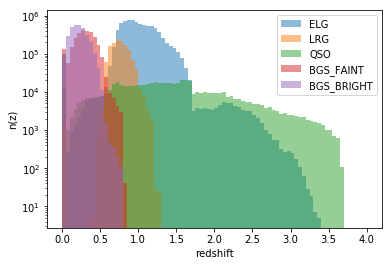

In [5]:
for targtype in ['ELG', 'LRG', 'QSO']:
    ii = (targets['DESI_TARGET'] & desi_mask.mask(targtype)) != 0
    hist(truth['TRUEZ'][ii], 80, (0,4), label=targtype, alpha=0.5, log=True)

for targtype in ['BGS_FAINT', 'BGS_BRIGHT']:
    ii = (targets['BGS_TARGET'] & bgs_mask.mask(targtype)) != 0
    hist(truth['TRUEZ'][ii], 80, (0,4), label=targtype, alpha=0.5, log=True)

legend()
xlabel('redshift')
ylabel('n(z)')

## n(z) grouped by true type

In [6]:
np.unique(truth['TEMPLATETYPE'])

array([b'BGS', b'ELG', b'LRG', b'QSO', b'STAR', b'WD'], 
      dtype='|S10')

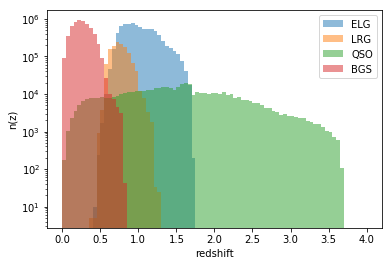

In [7]:
for objtype in [b'ELG', b'LRG', b'QSO', b'BGS']:
    ii = (truth['TEMPLATETYPE'] == objtype)
    hist(truth['TRUEZ'][ii], 80, (0,4), label=objtype.decode(), alpha=0.5, log=True)

legend()
xlabel('redshift')
ylabel('n(z)')

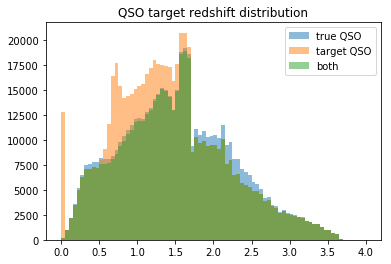

In [9]:
isQSO = (truth['TEMPLATETYPE'] == b'QSO')
isQSOtarget = (targets['DESI_TARGET'] & desi_mask.QSO) != 0
_ = hist(truth['TRUEZ'][isQSO], 80, (0,4), label='true QSO', alpha=0.5)
_ = hist(truth['TRUEZ'][isQSOtarget], 80, (0,4), label='target QSO', alpha=0.5)
_ = hist(truth['TRUEZ'][isQSO & isQSOtarget], 80, (0,4), label='both', alpha=0.5)
legend()
title('QSO target redshift distribution')

## Check what QSOs made it through fiberassignment

In [29]:
fadata = list()
for fafile in glob.glob(basedir+'/fiberassign/tile*.fits'):
    columns = ['TARGETID', 'FIBER', 'PRIORITY', 'DESI_TARGET']
    tmp, hdr = fitsio.read(fafile, 1, header=True, columns=columns)
    tmp = np.lib.recfunctions.append_fields(tmp, 'TILEID', np.full(len(tmp), hdr['TILEID'], dtype=int))
    fadata.append(tmp)

fadata = np.hstack(fadata)

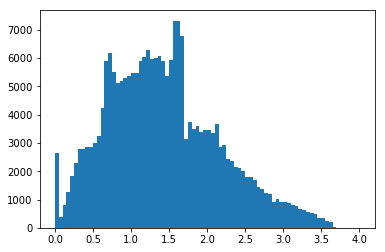

In [32]:
isQSOtarget = (fadata['DESI_TARGET'] & desi_mask.QSO) != 0
ii = np.in1d(truth['TARGETID'], fadata['TARGETID'][isQSOtarget])
_ = hist(truth['TRUEZ'][ii], 80, (0,4))

In [28]:
for x in np.unique(fadata['DESI_TARGET'].data):
    print(desi_mask.names(x))

[]
['SKY']
['BGS_ANY']
['MWS_ANY']
['STD_FSTAR', 'MWS_ANY']
['STD_WD', 'MWS_ANY']
['STD_BRIGHT', 'MWS_ANY']
['STD_FSTAR', 'STD_BRIGHT', 'MWS_ANY']
['BGS_ANY', 'MWS_ANY']


## Contaminants

In [ ]:
for objtype in [b'ELG', b'LRG', b'QSO']:
    subplot(211)
    ii = (truth['TEMPLATETYPE'] == objtype)
    n, bins, patches = hist(truth['TRUEZ'][ii], 80, (0,4), label=objtype.decode(), alpha=0.5, log=True)
    color = patches[0].get_facecolor() #[0:3]  #- don't include alpha portion
    
    #- Contaminants
    subplot(212)
    targtype = objtype.decode()
    jj = (targets['DESI_TARGET'] & desi_mask.mask(targtype)) != 0
    hist(truth['TRUEZ'][jj & ~ii], 80, (0,4), label=targtype+' contam',
         histtype='stepfilled', log=True, color=color)

subplot(211)
legend()
ylabel('true n(z)')

subplot(212)
legend()
ylabel('contaminants n(z)')
xlabel('redshift')

In [ ]:
for objtype in [b'ELG', b'LRG', b'QSO']:
    ii = (truth['TEMPLATETYPE'] == objtype)
    n, bins, patches = hist(truth['TRUEZ'][ii], 80, (0,4), label=objtype.decode(),
                            histtype='step', log=True, lw=2)
    color = patches[0].get_facecolor()[0:3]  #- don't include alpha portion
    
    #- Contaminants
    targtype = objtype.decode()
    jj = (targets['DESI_TARGET'] & desi_mask.mask(targtype)) != 0
    hist(truth['TRUEZ'][jj & ~ii], 80, (0,4), label=targtype+' contam',
         histtype='stepfilled', log=True, color=color, alpha=0.5)

legend()
ylabel('n(z)')
xlabel('redshift')

In [ ]:
len(truth)